### Continuing the Analysis with NBA.com stats

Here I am augmenting the initial team data collected from Basketball-Reference with similar statistics collected over "clutch" situations from [NBA.com](https://http://stats.nba.com/teams/clutch-four-factors/?sort=W_PCT&dir=-1). These situations are defined as occurring within the last five minutes of regulation or overtime with neither team leading by more than five points.  

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

import os
import requests

import pandas as pd
import numpy as np

import re

import nba_dot_com_scrape

Below I first scrape clutch four factors data from the 2001-02 through the 2017-18 seasons. After scraping, I mush everything into one data frame and drop any duplicate columns between the three sets of statistics.

In [2]:
url = 'http://stats.nba.com/teams/clutch-four-factors/?sort=W_PCT&dir=-1&Season=2017-18&SeasonType=Regular%20Season'
dfclutch4fact = nba_dot_com_scrape.scrape_nbacom_tmclutch_by_url(2002, 2018, url)

Now, bring in the data from Basketball-Reference and bind together with the NBA.com data and eventually compute the response variable `diffWP` all over again.

In [3]:
import pickle

In [4]:
with open('bbref_team_all_02_18.pkl', 'rb') as pick:
    df = pickle.load(pick)

In [5]:
df.index = [d.replace('/Oklahoma City', '') for d in df.index]

In [6]:
df = pd.concat([df, dfclutch4fact], axis = 1)

In [7]:
df.shape

(507, 41)

In [8]:
df = df.apply(pd.to_numeric, errors='ignore')
df['WP'] = df['W']/(df['W'] + df['L'])
df['xWP'] = df['PW']/(df['PW'] + df['PL'])
df['diffWP'] = df['WP'] - df['xWP']
df = df[df['WP'] >= 0.366]

In [9]:
df.shape

(391, 41)

In [10]:
df.corr()['diffWP'].sort_values(ascending=False)

diffWP                1.000000
ClutchWIN%            0.556964
ClutchW               0.534495
ClutcheFG%            0.276450
PL                    0.199196
DRtg                  0.193043
Age                   0.146272
W                     0.131497
ClutchFTA Rate        0.130083
WP                    0.126575
ClutchMIN             0.122025
DeFG%                 0.121508
ClutchGP              0.074876
SOS                   0.070097
ClutchOREB%           0.050164
OTOV%                 0.043939
ClutchOpp TOV%        0.042088
DFT/FGA               0.035015
TS%                   0.027940
OeFG%                 0.020936
OFT/FGA               0.000808
Pace                 -0.006890
FTr                  -0.009811
ORtg                 -0.014679
3PAr                 -0.018661
ORB%                 -0.042089
ClutchOpp OREB%      -0.066527
ClutchTOV%           -0.069528
DRB%                 -0.070394
DTOV%                -0.077577
L                    -0.114675
ClutchOpp FTA Rate   -0.169900
SRS     

Here, we begin setting up the dataframes for input into a regression model.

In [11]:
dfeval = df.drop(['W', 'L', 'PW', 'PL', 'WP', 'xWP', 'MOV', 'SRS', 'ORtg', 'DRtg', 'ClutchW', 'ClutchL', 'ClutchWIN%', 'ClutchGP'], axis=1)
dfeval['Year'] = [int(re.search('\d+$', teamyr).group(0)) for teamyr in dfeval.index]

In [12]:
#dfeval.iloc[:, 18:].corr()
dfeval.shape

(391, 28)

In [13]:
dfeval.rename(columns = lambda x: re.sub('\s', '', x), inplace = True)
dfeval.columns

Index(['Age', 'SOS', 'Pace', 'FTr', '3PAr', 'TS%', 'OeFG%', 'OTOV%', 'ORB%',
       'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'Arena', 'Attend.',
       'Attend./G', 'diffWP', 'ClutchMIN', 'ClutcheFG%', 'ClutchFTARate',
       'ClutchTOV%', 'ClutchOREB%', 'ClutchOppeFG%', 'ClutchOppFTARate',
       'ClutchOppTOV%', 'ClutchOppOREB%', 'Year'],
      dtype='object')

In [14]:
import seaborn as sns
dfclutchdiffWP = pd.concat([dfeval.iloc[:, -11:-2], dfeval.iloc[:, -12]], axis=1)
sns.pairplot(dfclutchdiffWP)

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [16]:
#df_norm['Ones'] = 1
dfeval = dfeval.apply(pd.to_numeric, errors='ignore')
dfeval['Ones'] = np.ones(len(dfeval))
dfeval.columns

Index(['Age', 'SOS', 'Pace', 'FTr', '3PAr', 'TS%', 'OeFG%', 'OTOV%', 'ORB%',
       'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'Arena', 'Attend.',
       'Attend./G', 'diffWP', 'ClutchMIN', 'ClutcheFG%', 'ClutchFTARate',
       'ClutchTOV%', 'ClutchOREB%', 'ClutchOppeFG%', 'ClutchOppFTARate',
       'ClutchOppTOV%', 'ClutchOppOREB%', 'Year', 'Ones'],
      dtype='object')

Set up the train, validation and test sets manually, so everything from 2001-02 through 2011-12 are in the training set with the next five seasons are in the validation set (for now) with the test (holdout) set as the last season (2017-18).

In [17]:
#dftrain = df_norm[df_norm['Year'] <= 2017]
dftrain = dfeval[dfeval['Year'] <= 2017]

In [18]:
#dftest = df_norm[df_norm['Year'] > 2017]
#dftest.head()
#dftest = dfeval[(dfeval['Year'] > 2016) & (dfeval['Year'] <= 2017)]

In [19]:
dfholdout = dfeval[dfeval['Year'] > 2017]

In [20]:
Ytrain = dftrain['diffWP']
Xtrain = dftrain.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
#X = dftrain[['Age', 'ClutchWIN%', 'ClutchMIN', 'ClutcheFG%', 'ClutchFTARate', 'ClutchOREB%', 'ClutchOppeFG%', 'ClutchOppFTARate', 'ClutchOppOREB%', 'ClutchASTRatio']]
#X = dftrain[['ClutchOffRtg', 'ClutchDefRtg']]
#X.dtypes

Let's run an initial model with statsmodels on our training set.

In [21]:
lml = sm.OLS(Ytrain,Xtrain)

In [22]:
fit = lml.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 diffWP   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     10.65
Date:                Mon, 17 Sep 2018   Prob (F-statistic):           2.34e-28
Time:                        16:11:15   Log-Likelihood:                 814.03
No. Observations:                 370   AIC:                            -1580.
Df Residuals:                     346   BIC:                            -1486.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Age                  0.0042      0.001      3.950      0.000       0.002       0.006
SOS                 -0.0024      0.004     -0.567      0.571      -0.011       0.006
Pace                 0.0013      0.001      1.832      0.068    -9.3e-05       0.003
FTr                  0.5806      0.657      0.884      0.377      -0.711       1.872
3PAr                -0.0654      0.039     -1.685      0.093      -0.142       0.011
TS%                  3.2427      3.046      1.065      0.288      -2.748       9.234
OeFG%               -3.3781      2.696     -1.253      0.211      -8.681       1.925
OTOV%                0.0067      0.002      3.406      0.001       0.003       0.011
ORB%                -0.0012      0.001     -1.483      0.139      -0.003       0.000
OFT/FGA             -1.5199      1.358     -1.119      0.264      -4.191       1.151
DeFG%                0.8830      0.111      7.965      0.000       0.665       1.101
DTOV%               -0.0093      0.002     -5.234      0.000      -0.013      -0.006
DRB%                -0.0033      0.001     -3.812      0.000      -0.005      -0.002
DFT/FGA              0.3224      0.077      4.161      0.000       0.170       0.475
ClutchMIN        -4.612e-06   5.55e-05     -0.083      0.934      -0.000       0.000
ClutcheFG%           0.0025      0.000      5.733      0.000       0.002       0.003
ClutchFTARate        0.0652      0.018      3.608      0.000       0.030       0.101
ClutchTOV%          -0.0020      0.001     -2.448      0.015      -0.004      -0.000
ClutchOREB%          0.0010      0.000      2.851      0.005       0.000       0.002
ClutchOppeFG%       -0.0033      0.000     -7.371      0.000      -0.004      -0.002
ClutchOppFTARate    -0.0883      0.019     -4.766      0.000      -0.125      -0.052
ClutchOppTOV%        0.0019      0.001      2.507      0.013       0.000       0.003
ClutchOppOREB%      -0.0013      0.000     -3.230      0.001      -0.002      -0.000
Ones                -0.2547      0.232     -1.097      0.273      -0.711       0.202
==============================================================================
Omnibus:                        0.426   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.540
Skew:                           0.063   Prob(JB):                        0.763
Kurtosis:                       2.861   Cond. No.                     6.83e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The training $R^2$ looks OK, and it appears as if the significant features include every clutch performance metric and all the defensive all game situation performance metrics.

Let's first take a look at model adequacy and then examine test set performance.

In [23]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

(array([  8.,  18.,  42.,  63., 100.,  57.,  44.,  26.,  10.,   2.]),
 array([-0.07095124, -0.05552606, -0.04010088, -0.02467569, -0.00925051,
         0.00617467,  0.02159985,  0.03702503,  0.05245022,  0.0678754 ,
         0.08330058]),
 <a list of 10 Patch objects>)

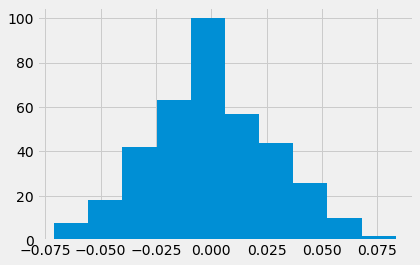

In [24]:
yhat = fit.predict(Xtrain)
res = Ytrain-yhat
plt.hist(res)

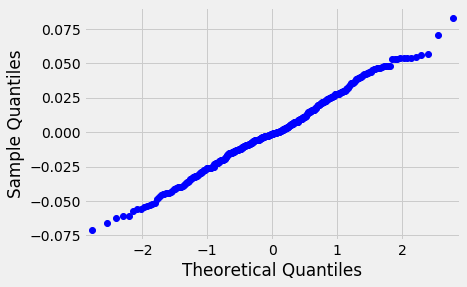

In [25]:
sm.qqplot(res)
plt.show()

([], <a list of 0 Text xticklabel objects>)

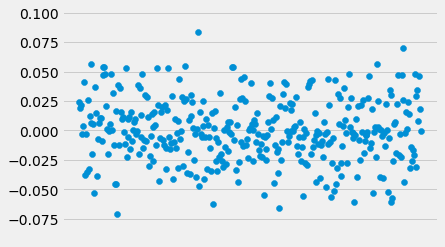

In [26]:
plt.scatter(Xtrain.index, res)
plt.xticks([])

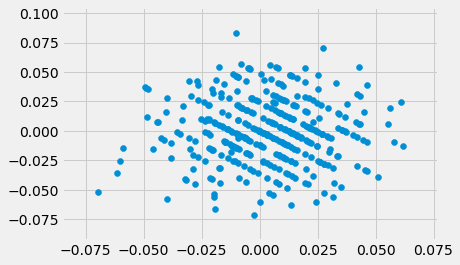

In [27]:
plt.scatter(yhat, res)

Everything looks OK -- the residuals look normally distributed enough, of relatively constant variance, and not autocorrelated.

In [28]:
Yholdout = dfholdout['diffWP']
Xholdout = dfholdout.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
Yhat_holdout = fit.predict(Xholdout)

In [29]:
sqerr = (Yholdout-Yhat_holdout)**2

In [30]:
sqtot = (Yholdout-Yholdout.mean())**2

In [31]:
#r2adj = (sum(sqerr)/(len(Xtest) - len(fit.params) - 1))/(sum(sqtot)/(len(Xtest)-1))
rsqtest = 1-(sum(sqerr)/sum(sqtot))
print(rsqtest)

0.3050735836409477


The test $R^2$ is lower than the train $R^2$. Overfitting might be an issue here, let's see what happens with some feature selection and regularization.

In [32]:
from sklearn import preprocessing, linear_model, pipeline, model_selection, feature_selection, metrics

In [33]:
select_pipe = pipeline.Pipeline(
    [("std", preprocessing.StandardScaler()),
    ("select",
      feature_selection.SelectKBest(
          score_func=feature_selection.f_regression, k=3)),
     ("ols", linear_model.LinearRegression())])
select_pipe.get_params()

{'memory': None,
 'ols': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'ols__copy_X': True,
 'ols__fit_intercept': True,
 'ols__n_jobs': 1,
 'ols__normalize': False,
 'select': SelectKBest(k=3, score_func=<function f_regression at 0x1c1e85ca60>),
 'select__k': 3,
 'select__score_func': <function sklearn.feature_selection.univariate_selection.f_regression>,
 'std': StandardScaler(copy=True, with_mean=True, with_std=True),
 'std__copy': True,
 'std__with_mean': True,
 'std__with_std': True,
 'steps': [('std', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('select',
   SelectKBest(k=3, score_func=<function f_regression at 0x1c1e85ca60>)),
  ('ols',
   LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]}

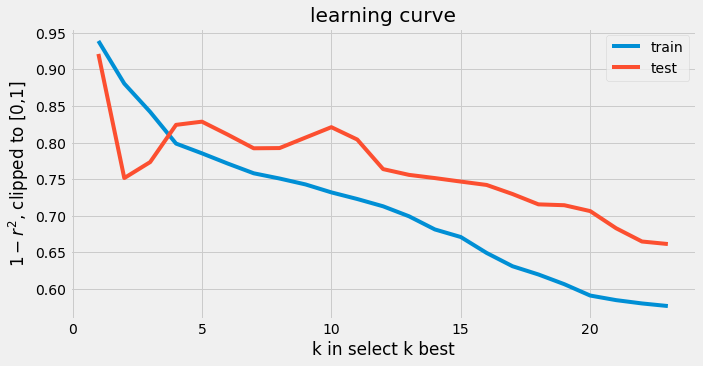

In [76]:
plt.figure(figsize=(10,5))
train_scores = []
test_scores = []
num_fs = range(1, len(Xtrain.columns), 1)
for i, num_f in enumerate(num_fs):
    select_pipe.set_params(select__k=num_f)
    train_splits = []
    test_splits = []
    for yr in range(2012, 2017):
        dftrain = dfeval[dfeval['Year'] <= yr]
        dftest = dfeval[(dfeval['Year'] > yr) & (dfeval['Year'] <= 2017)]
        
        Y = dftrain['diffWP']
        X = dftrain.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        Ytest = dftest['diffWP']
        Xtest = dftest.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        
        fit = select_pipe.fit(X.drop('Ones', axis=1), Y)
        train_splits.append(fit.score(X.drop('Ones', axis=1), Y))
        test_splits.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))
        
    train_scores.append(np.mean(train_splits))
    test_scores.append(np.mean(test_splits))

plt.plot(num_fs, 1 - np.array(train_scores), label="train")
plt.plot(num_fs, 1 - np.array(test_scores), label="test")
plt.xlabel("k in select k best")
plt.ylabel("$1-r^2$, clipped to [0,1]")
plt.title("learning curve")
plt.legend()

In [78]:
train_scores[6]

0.24211670086618944

In [79]:
test_scores[6]

0.20789038210490646

In [35]:
select_pipe.set_params(select__k=7)
k_best_fit = select_pipe.fit(Xtrain.drop('Ones', axis=1),Ytrain)
features = select_pipe.named_steps['select']
feat = Xtrain.drop('Ones', axis=1).columns[features.get_support()]

In [36]:
k_best_fit.score(Xtrain.drop('Ones', axis=1), Ytrain)

0.251658669309041

In [37]:
Yholdout = dfholdout['diffWP']
Xholdout = dfholdout.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)

In [38]:
k_best_fit.score(Xholdout.drop('Ones', axis=1), Yholdout)

0.3121380628620015

In [39]:
coefs = list(zip(list(feat), select_pipe.named_steps["ols"].coef_))

([<matplotlib.axis.YTick at 0x1c1e399cc0>,
 <a list of 7 Text yticklabel objects>)

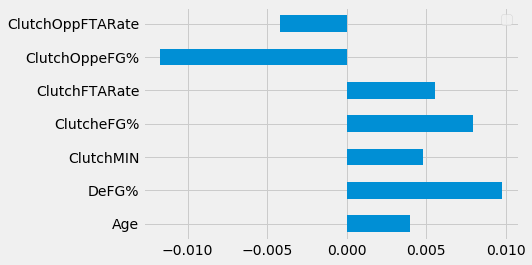

In [40]:
coefs_df = pd.DataFrame.from_records(coefs)
coefs_df.plot.barh()
plt.legend([])
plt.yticks(range(0, len(coefs_df)), coefs_df[0])

Let's now take a look at model adequacy for this fit:

In [41]:
pred = k_best_fit.predict(Xtrain.drop('Ones', axis=1))
res_kbest = Ytrain-pred

(array([ 7., 10., 31., 48., 87., 77., 56., 29., 21.,  4.]),
 array([-0.08438614, -0.06779385, -0.05120157, -0.03460928, -0.018017  ,
        -0.00142471,  0.01516757,  0.03175986,  0.04835214,  0.06494443,
         0.08153671]),
 <a list of 10 Patch objects>)

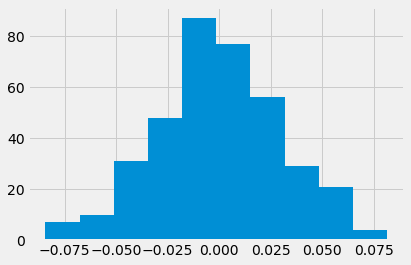

In [42]:
plt.hist(res_kbest)

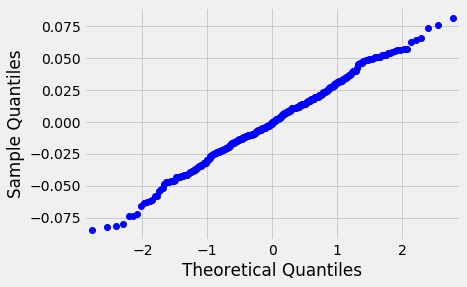

In [43]:
sm.qqplot(res_kbest)
plt.show()

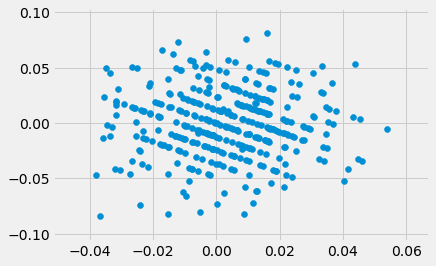

In [44]:
plt.scatter(pred, res_kbest)

OK this seems reasonable, even if $R^2$ isn't high across train/test or for the best K train/holdout (and holdout is better). But the selected features set does make sense, even if `ClutchMIN` happened to not figure in the "baseline" model.

Let us see if there are any improvements to be found using Ridge regression.

In [45]:
ridge_pipe = pipeline.Pipeline([
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("ridge", linear_model.Ridge())
    ])

In [46]:
# alphas look best when logspaced
alphas = np.logspace(5, .5, num=50)
coefs = []
train_scores = []
test_scores = []
preds = []
fits = []

# loop through each of the 50 alphas
for i, alpha in enumerate(alphas):
    # set the alpha for our pipeline
    ridge_pipe.set_params(ridge__alpha=alpha)
    
    train_splits = []
    test_splits = []
    
    for yr in range(2012, 2017):
        dftrain = dfeval[dfeval['Year'] <= yr]
        dftest = dfeval[(dfeval['Year'] > yr) & (dfeval['Year'] <= 2017)]
        
        Y = dftrain['diffWP']
        X = dftrain.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        Ytest = dftest['diffWP']
        Xtest = dftest.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        
        fit = ridge_pipe.fit(X.drop('Ones', axis=1), Y)
        train_splits.append(fit.score(X.drop('Ones', axis=1), Y))
        test_splits.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))
        
    train_scores.append(np.mean(train_splits))
    test_scores.append(np.mean(test_splits))
    
    fit_train = ridge_pipe.fit(Xtrain.drop('Ones', axis=1), Ytrain)
    fits.append(fit_train)
    preds.append(fit_train.predict(Xtrain.drop('Ones', axis=1)))
    coefs.append(ridge_pipe.named_steps["ridge"].coef_)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


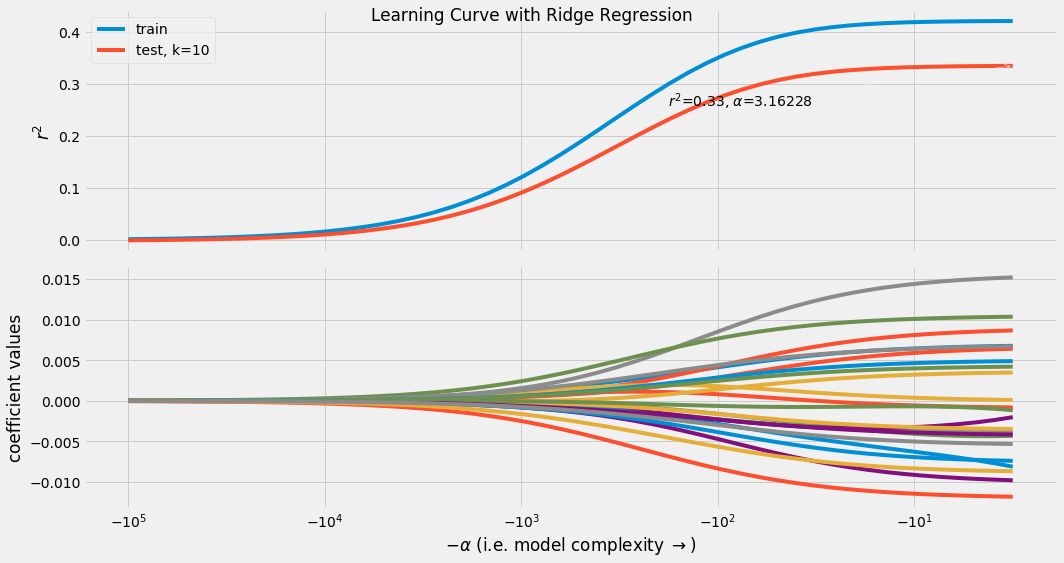

In [47]:
# set up the figure. I'll do the learning curve above and coefficient path below
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
# list of arrays -> single array
coef_arr = np.squeeze(coefs, axis=1)
# grab the first axis
ax0 = axes.flat[0]
# plot train and test curves
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
# find the index of the best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

# grab the second axis
ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Ridge Regression")
plt.xscale("symlog")

In [50]:
np.mean(train_scores[best_i])

0.4208785279434242

In [51]:
np.mean(test_scores[best_i])

0.33474219232808256

Let's first look at model adequacy for the best ridge fit. First get and look at the residuals.

In [52]:
res_ridge = Ytrain-preds[best_i]

(array([  9.,  19.,  38.,  61., 103.,  56.,  45.,  27.,  10.,   2.]),
 array([-0.07058947, -0.05529923, -0.04000898, -0.02471874, -0.00942849,
         0.00586175,  0.021152  ,  0.03644224,  0.05173249,  0.06702274,
         0.08231298]),
 <a list of 10 Patch objects>)

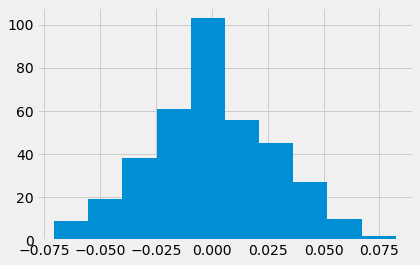

In [53]:
plt.hist(res_ridge)

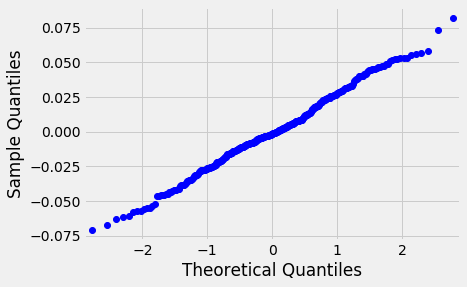

In [54]:
sm.qqplot(res_ridge)
plt.show()

([], <a list of 0 Text xticklabel objects>)

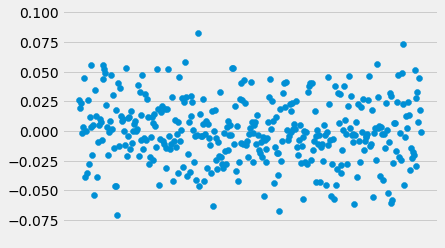

In [55]:
plt.scatter(Xtrain.index, res_ridge)
plt.xticks([])

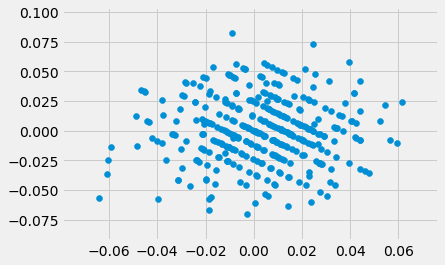

In [56]:
plt.scatter(preds[best_i], res_ridge)

Everything seems to check out from the above. Now let's look at the coefficients.

In [57]:
coefs[best_i]

array([ 0.00678907, -0.00080688,  0.00349928, -0.00430262, -0.00381272,
       -0.00200788, -0.00810447,  0.00642422, -0.00345567, -0.00114625,
        0.01521935, -0.0097844 , -0.0073853 ,  0.00868564,  0.00011341,
        0.01037384,  0.00673067, -0.00414439,  0.00490131, -0.01180983,
       -0.00866842,  0.00421705, -0.00531331])

In [58]:
coefs_sort = sorted(list(zip(Xtrain.columns, coefs[best_i])), key=lambda t: abs(t[1]), reverse=True)[:10]

([<matplotlib.axis.YTick at 0x1c25dd6358>,
 <a list of 10 Text yticklabel objects>)

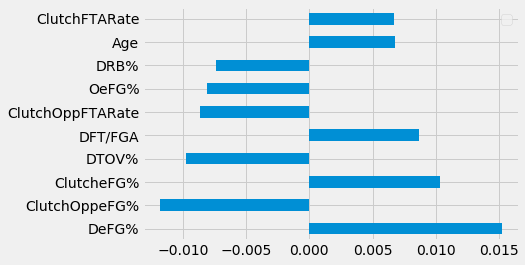

In [59]:
coef_df = pd.DataFrame.from_records(coefs_sort)
coef_df.plot.barh()
plt.legend([])
plt.yticks(range(0, len(coef_df)), coef_df[0])

We see a mix of clutch and all-situations performance metrics involved here. Given the positive coeffiicents for `ClutcheFG` and `ClutchFTARate`, teams that overperform tend to shoot efficiently and do a good job of getting to the free throw line (relative to the number of shots they take) in clutch situations. The negative coefficients associated with `ClutchOppeFG%` and `ClutchOppFTARate` seem to indicate that in cluthc situations, overperforming teams also do a good job of preventing their opponents from efficiently making shots and getting to the free throw line (relative to the number of shots they take) in clutch situations. That `Age` has a positive coefficient might indicate that older, more experienced teams also have a tendency to overperform rather than underperform.

The largest positive coefficient in the model belongs to `DeFG%`, which along with the positive coefficient for `DFT/FGA` and negative coefficients for both `DTOV%` and `DRB%` (overall defensive turnover percentage and defensive rebounding percentage), suggests that teams that overperform tend struggle on defense in general situations. These teams, however, tend to shoot more efficinetly in all situations, as indicated by the positive coefficient for `OeFG%`. One interpretation might be that teams that tend to overperform will also tend to keep games close enough to be winnable (by giving up more points than they should) -- and then potentially prevail in clutch situations.

In [60]:
Xholdout.columns

Index(['Age', 'SOS', 'Pace', 'FTr', '3PAr', 'TS%', 'OeFG%', 'OTOV%', 'ORB%',
       'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'ClutchMIN',
       'ClutcheFG%', 'ClutchFTARate', 'ClutchTOV%', 'ClutchOREB%',
       'ClutchOppeFG%', 'ClutchOppFTARate', 'ClutchOppTOV%', 'ClutchOppOREB%',
       'Ones'],
      dtype='object')

In [61]:
best_fit = fits[best_i]
best_fit.score(Xtrain.drop('Ones', axis=1), Ytrain)

0.41230897322221505

In [62]:
best_fit.score(Xholdout.drop('Ones', axis=1), Yholdout)

0.30040497286645773

This doesn't appear to improve on the SelectKBest result but the above coefficient plot seems reasonable enough.

### Exploration with Lasso

In [63]:
lasso_pipe = pipeline.Pipeline([
     ("std", preprocessing.StandardScaler()),
     ("lasso", linear_model.Lasso())
    ])

In [64]:
# alphas look best when logspaced
alphas = np.logspace(-4, -2, num=50)
coefs = []
train_scores = []
test_scores = []
preds = []
fits = []
trscore = []
holdoutscore = []

# loop through each of the 50 alphas
for i, alpha in enumerate(alphas):
    # set the alpha for our pipeline
    lasso_pipe.set_params(lasso__alpha=alpha)
    
    train_splits = []
    test_splits = []
    
    for yr in range(2012, 2017):
        dftrain = dfeval[dfeval['Year'] <= yr]
        dftest = dfeval[(dfeval['Year'] > yr) & (dfeval['Year'] <= 2017)]
        
        Y = dftrain['diffWP']
        X = dftrain.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        Ytest = dftest['diffWP']
        Xtest = dftest.drop(['diffWP', 'Year', 'Arena', 'Attend.', 'Attend./G'], axis = 1)
        
        fit = lasso_pipe.fit(X.drop('Ones', axis=1), Y)
        train_splits.append(fit.score(X.drop('Ones', axis=1), Y))
        test_splits.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))
        
    train_scores.append(np.mean(train_splits))
    test_scores.append(np.mean(test_splits))
    
    fit_train = lasso_pipe.fit(Xtrain.drop('Ones', axis=1), Ytrain)
    fits.append(fit_train)
    preds.append(fit_train.predict(Xtrain.drop('Ones', axis=1)))
    trscore.append(fit_train.score(Xtrain.drop('Ones', axis=1), Ytrain))
    holdoutscore.append(fit_train.score(Xholdout.drop('Ones', axis=1), Yholdout))
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


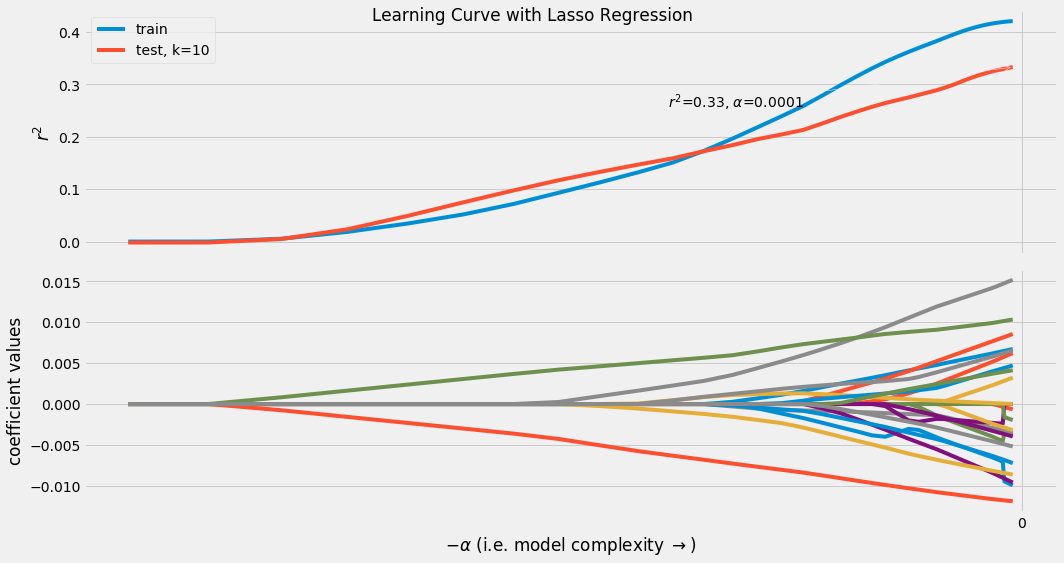

In [65]:
# set up the figure. I'll do the learning curve above and coefficient path below
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
# list of arrays -> single array
coef_arr = np.squeeze(coefs, axis=1)
# grab the first axis
ax0 = axes.flat[0]
# plot train and test curves
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
# find the index of the best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

# grab the second axis
ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Lasso Regression")
plt.xscale("symlog")

In [66]:
np.mean(train_scores[best_i])

0.42087642040360784

In [67]:
np.mean(test_scores[best_i])

0.3330287244888221

In [726]:
sorted(list(zip(Xtrain.columns, coefs[best_i])), key=lambda t: abs(t[1]), reverse=True)

[('DeFG%', 0.01518185724514334),
 ('ClutchOppeFG%', -0.011881015253311979),
 ('ClutcheFG%', 0.010328793591228676),
 ('OeFG%', -0.009937325173497474),
 ('DTOV%', -0.009599151282719048),
 ('ClutchOppFTARate', -0.008629253414756162),
 ('DFT/FGA', 0.008565834411150688),
 ('DRB%', -0.007220365373637763),
 ('Age', 0.006719279274281504),
 ('ClutchFTARate', 0.006552661564457711),
 ('OTOV%', 0.0062283974142929134),
 ('ClutchOppOREB%', -0.00518938370614031),
 ('ClutchOREB%', 0.0047107402289432426),
 ('ClutchOppTOV%', 0.004128960900282117),
 ('ClutchTOV%', -0.003966224699904067),
 ('FTr', -0.0036705789343191688),
 ('3PAr', -0.0035711114417297583),
 ('Pace', 0.0032293198632527553),
 ('ORB%', -0.003209707429592072),
 ('OFT/FGA', -0.0019622047140252143),
 ('SOS', -0.0006481490432091333),
 ('ClutchMIN', 7.669890133913288e-06),
 ('TS%', -0.0)]

In [727]:
trbest = trscore[best_i]
trbest

0.4121056655913343

In [728]:
holdoutbest = holdoutscore[best_i]
holdoutbest

0.30313144770031175